In [3]:
import time
import PIL
import prettytensor as pt
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import cv2
import inception
import pandas as pd
from sklearn.model_selection import train_test_split
import scipy as sp
from scipy import ndimage
import random
# import inception

## Creating datasets

### Aamir Khan

In [6]:
# train
dir_a_test = 'resize_aamir/test/'
a_test = []
list_a_test = os.listdir(dir_a_test)
for i in range(0,len(list_a_test)):
    path_a_test = dir_a_test + list_a_test[i]
    im  = ndimage.imread(path_a_test)
    a_test.append(im)
a_test = np.array(a_test)

#test
dir_a_train = 'resize_aamir/train/'
a_train = []
list_a_train = os.listdir(dir_a_train)
for i in range(0,len(list_a_train)):
    path_a_train = dir_a_train + list_a_train[i]
    im = ndimage.imread(path_a_train)
    a_train.append(im)
a_train = np.array(a_train)

# concat
a = np.concatenate((a_train,a_test))

#flat
a_flat = a.reshape([-1,30000])

# labels
labels_a = []
for i in range(0,len(list_a_test) + len(list_a_train)):
    labels_a.append([1,0,0])

In [7]:
temp_a = []
for i in range(0,len(list_a_test) + len(list_a_train)):
    temp_a.append([a_flat[i], labels_a[i]])

### Salman Khan

In [8]:
dir_sal = 'resize_salman/'
sal = []
list_sal = os.listdir(dir_sal)
for i in range(0,len(list_sal)):
    path_sal = dir_sal + list_sal[i]
    im = cv2.imread(path_sal)
    sal.append(im)
sal = np.array(sal)
sal_flat = sal.reshape([-1,30000])

# labels
labels_sal = []
for i in range(0,len(list_sal)):
    labels_sal.append([0,1,0])

In [9]:
temp_sal = []
for i in range(0,len(list_sal)):
    temp_sal.append([sal_flat[i],labels_sal[i]])

### Shahrukh Khan

In [10]:
dir_srk = 'resize_shahrukh/'
srk = []
list_srk = os.listdir(dir_srk)
for i in range(0,len(list_srk)):
    path_srk = dir_srk + list_srk[i]
    im = cv2.imread(path_srk)
    srk.append(im)
srk = np.array(srk)
srk_flat = srk.reshape([-1,30000])

# labels
labels_srk = []
for i in range(0,len(list_srk)):
    labels_srk.append([0,0,1])

In [11]:
temp_srk = []
for i in range(0, len(list_srk)):
    temp_srk.append([srk_flat[i],labels_srk[i]])

## Creating train and test datasets from the images

In [14]:
data = temp_a + temp_sal + temp_srk
data = np.array(data)
data.shape
for i in range(1329):
    data[:,0][i] = data[:,0][i].astype(float)
for i in range(1329):
    data[:,1][i] = np.asfarray(data[:,1][i])

In [15]:
df = pd.DataFrame({'img' : data[:,0], 'label' : data[:,1]})
df['cls'] = df['label'].apply(lambda x : np.argmax(x))
df_x = df['img']
df_y = df[['label','cls']]

In [16]:
df.head(2)

,img,label,cls
0,"[234.0, 208.0, 183.0, 233.0, 203.0, 177.0, 242...","[1.0, 0.0, 0.0]",0
1,"[161.0, 147.0, 144.0, 166.0, 152.0, 149.0, 168...","[1.0, 0.0, 0.0]",0


In [17]:
train_x , test_x, train_y, test_y = train_test_split(df_x, df_y, test_size=0.25)

In [18]:
test_label = np.array(list(test_y['label']))
train_label = np.array(list(train_y['label']))

In [19]:
cls_test = np.array(list(test_y['cls']))
cls_train = np.array(list(train_y['cls']))

In [20]:
train_x = (np.array(list(train_x)))
# train_y = (np.array(list(train_x)))
test_x = (np.array(list(test_x)))


In [21]:
train_x.shape

(996, 30000)

In [22]:
train_images = []
for i in range(train_x.shape[0]):
    train_images.append(train_x[i].reshape((100,100,3)))
train_images = np.array(train_images)

In [23]:
test_images = []
for i in range(test_x.shape[0]):
    test_images.append(test_x[i].reshape((100,100,3)))
test_images = np.array(test_images)

### Helper functions to create a convolutional layer

In [24]:
filter_size1 = 10
filter_size2 = 10
num_filters1 = 20
num_filters2 = 60
img_size = 100
num_channels = 3
img_size_flat = img_size * img_size * num_channels
img_shape = [img_size, img_size, num_channels]
num_classes = 3
fc_size = 256

In [25]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape=shape,stddev=0.05))
    
def new_biases(length):
    return tf.Variable(tf.constant(0.05,shape=[length]))

In [26]:
def new_conv_layer(input,num_input_channels,filter_size,num_filters,use_pooling=True):
    shape = [filter_size,filter_size,num_input_channels,num_filters]
    weights = new_weights(shape)
    biases = new_biases(length=num_filters)
    layer = tf.nn.conv2d(input, weights, strides = [1,1,1,1], padding='SAME')
    layer += biases
    if use_pooling:
        layer = tf.nn.max_pool(layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    layer = tf.nn.relu(layer)
    return layer, weights

In [27]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer,[-1,num_features])
    return layer_flat, num_features

In [28]:
def new_fc_layer(input, num_inputs, num_outputs, use_relu=True):
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input,weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

In [29]:
img_size_flat = 30000

## Load inception model

In [30]:
model = inception.Inception()

In [61]:
class_names = ['Aamir Khan', 'Salman Khan', 'Shahrukh Khan']

In [73]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):
    assert len(images) == len(cls_true)
    fig, axes = plt.subplots(3, 3)

    if cls_pred is None:
        hspace = 0.6
    else:
        hspace = 0.8
    fig.subplots_adjust(hspace=hspace, wspace=0.6)

    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i],
                      interpolation=interpolation)

            cls_true_name = class_names[cls_true[i]]

            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            ax.set_xlabel(xlabel)
            ax.set_xticks([])
            ax.set_yticks([])

### Calculate transfer value

In [31]:
from inception import transfer_values_cache

In [32]:
file_path_cache_train = os.path.join('taskData','inception_custom_train.pkl')
file_path_cache_test = os.path.join('taskData/','inception_custom_test.pkl')

In [33]:
print("Processing Inception transfer-values for training-images ...")

transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                              images=train_images,
                                              model=model)

Processing Inception transfer-values for training-images ...
- Processing image:    996 / 996
- Data saved to cache-file: taskData/inception_custom_train.pkl


In [34]:
print("preprocessing Inception transfer-values for training-images ...")

transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             images=test_images,
                                             model=model)

preprocessing Inception transfer-values for training-images ...
- Processing image:    333 / 333
- Data saved to cache-file: taskData/inception_custom_test.pkl


In [35]:
def plot_transfer_values(i):
    print("Input image:")
    
    # Plot the i'th image from the test-set.
    plt.imshow(test_images[i], interpolation='nearest')
    plt.show()

    print("Transfer-values for the image using Inception model:")
    
    # Transform the transfer-values into an image.
    img = transfer_values_test[i]
    img = img.reshape((32, 64))

    # Plot the image for the transfer-values.
    plt.imshow(img, interpolation='nearest', cmap='Reds')
    plt.show()

Input image:


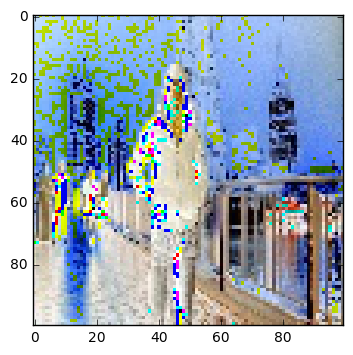

Transfer-values for the image using Inception model:


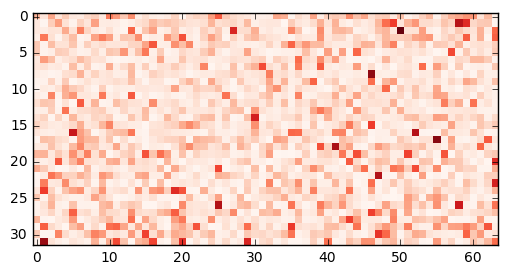

In [36]:
plot_transfer_values(i=19)

Input image:


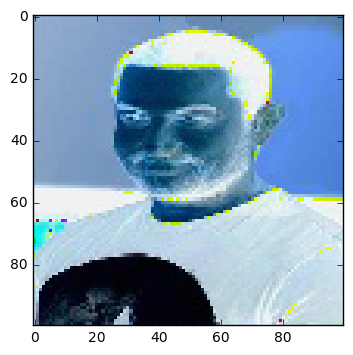

Transfer-values for the image using Inception model:


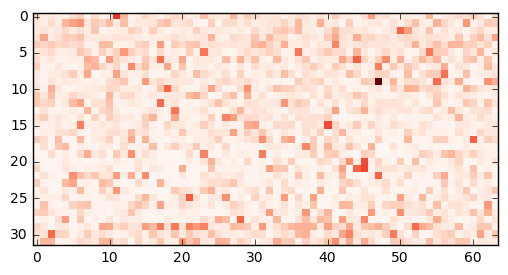

In [37]:
plot_transfer_values(i=99)

### New_classifier

In [38]:
transfer_len = model.transfer_len

In [39]:
x = tf.placeholder(tf.float32, shape=[None,transfer_len], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

### Neural Networks

In [40]:
x_pretty = pt.wrap(x)
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        fully_connected(size=1024, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

### Optimization Method

In [41]:
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step)

### Classification Accuracy

In [42]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [43]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Tensorflow run

In [44]:
session = tf.Session()
session.run(tf.global_variables_initializer())

### Helper function to perform batch training

In [45]:
train_batch_size = 64

In [46]:
def random_batch():
    num_images = len(transfer_values_train)
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)
    x_batch = transfer_values_train[idx]
    y_batch = train_label[idx]
    return x_batch, y_batch

In [47]:
def optimize(num_iterations):
    start_time = time.time()
    for i in range(num_iterations):
        x_batch, y_true_batch = random_batch()
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))
    end_time = time.time()

    time_dif = end_time - start_time

    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [57]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = test_images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]

    n = min(9, len(images))
    
    # Plot the first n images.
    plot_images(images=images[0:n],
                cls_true=cls_true[0:n],
                cls_pred=cls_pred[0:n])

In [49]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cls_pred):
    cm = confusion_matrix(y_true=cls_test,
                          y_pred=cls_pred)

    for i in range(num_classes):
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)
        
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

## Helper function for calculating classifications

In [50]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(transfer_values, labels, cls_true):
    # Number of images.
    num_images = len(transfer_values)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: transfer_values[i:j],
                     y_true: labels[i:j]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j
        
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

In [51]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.

    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

In [52]:
def predict_cls_test():
    return predict_cls(transfer_values = transfer_values_test,
                       labels = test_label,
                       cls_true = cls_test)

In [53]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [70]:
print_test_accuracy(show_example_errors=False,
                    show_confusion_matrix=False)

Accuracy on Test-Set: 82.9% (276 / 333)


In [71]:
from datetime import timedelta

In [77]:
optimize(num_iterations=1000)

Global Step:  13100, Training Batch Accuracy: 100.0%
Global Step:  13200, Training Batch Accuracy: 100.0%
Global Step:  13300, Training Batch Accuracy: 100.0%
Global Step:  13400, Training Batch Accuracy: 100.0%
Global Step:  13500, Training Batch Accuracy: 100.0%
Global Step:  13600, Training Batch Accuracy: 100.0%
Global Step:  13700, Training Batch Accuracy: 100.0%
Global Step:  13800, Training Batch Accuracy: 100.0%
Global Step:  13900, Training Batch Accuracy: 100.0%
Global Step:  14000, Training Batch Accuracy: 100.0%
Time usage: 0:00:36


Accuracy on Test-Set: 83.2% (277 / 333)
Example errors:
Confusion Matrix:
[108   3   5] (0) Aamir Khan
[ 0 83 22] (1) Salman Khan
[ 4 22 86] (2) Shahrukh Khan
 (0) (1) (2)


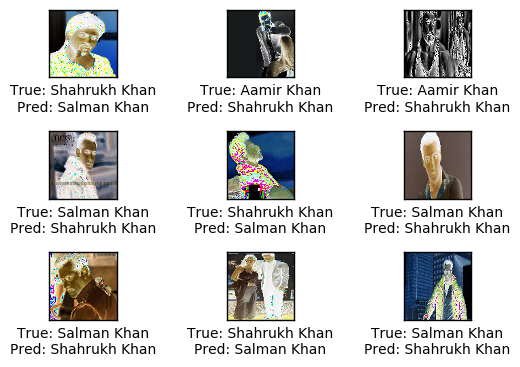

In [78]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)